In [3]:
import argparse
import glob
import io  # for BytesIO
import itertools
# Imports Python standard library logging
import logging
import os
import tarfile
import time
import zipfile
from datetime import datetime

import numpy as np
import pandas as pd
import requests
# W&B
import wandb
# import fastparquet
from google.cloud import storage
from sklearn.ensemble import RandomForestClassifier
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm


In [10]:
import os

# Set the path to your JSON key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/Users/daniel/Synology_Ongoing/HES_Data_Science/test/secrets/mlops.json'


In [12]:

# Utils
def list_files(project, bucket_name, prefix=''):
    """List all files in a GCS bucket with a given prefix."""
    storage_client = storage.Client(project=project)
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)
    return [blob.name for blob in blobs]

def read_parquet_from_gcs(project, bucket_name, file):
    """Read Parquet file from GCS."""
    storage_client = storage.Client(project=project)
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(file)
    content = blob.download_as_bytes()  # Download the content as bytes
    return pd.read_parquet(io.BytesIO(content))


# Specify a prefix if you want to list files in a specific directory within the bucket
GCP_PROJECT="mlops-400214"
GCS_BUCKET_URI="harvard_mlops_bucketd"
PREFIX = 'gold/9/23/'

# # Load Data
print('Loading data')

# Get the list of files
files = list_files(GCP_PROJECT, GCS_BUCKET_URI, PREFIX)

# Read Parquet files from GCS and concatenate into a single DataFrame
start_time = time.time()
df_list = []
for file in files:
    print(file)
    logging.debug(file)
    df = read_parquet_from_gcs(GCP_PROJECT, GCS_BUCKET_URI, file)
    df_list.append(df)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(df_list)

execution_time = (time.time() - start_time) / 60.0
logging.debug("Download execution time (mins)", execution_time)

# # Load X & Y
# # Build data x, y
RANDOM_SEED = 42
response = ['actor']
features = ['length', 'entropy', 
       'number_of_vowels', 'number_of_consonants', 'number_of_numbers',
       'number_of_specials'] #, 'is_most_frequent_tld', 'meaningful_word_ratio']

X_values = df[features]
Y_values = df[response]['actor']

# Label Encoding
le = LabelEncoder()
le.fit(Y_values)
logging.debug(le.classes_)
Y_values_le = le.transform(Y_values)
original_labels = list(le.inverse_transform(range(0,30)))


# # Split Data
test_percent = 0.10
validation_percent = 0.5

# # Split data into train / test
X_train, X_test_val, y_train, y_test_val  = train_test_split(X_values, Y_values_le, random_state=RANDOM_SEED, stratify=Y_values_le, test_size=test_percent)

# # Split data into train / validate
X_test, X_val, y_test, y_val  = train_test_split(X_test_val, y_test_val, random_state=RANDOM_SEED, stratify=y_test_val, test_size=validation_percent)

logging.debug('\nTrain/Test/Val Split')
logging.debug("train_x count:", len(X_train))
logging.debug("validate_x count:", len(X_val))
logging.debug("test_x count:", len(X_test))



In [15]:

# # Initialize a W&B run
# Login into wandb
wandb.login(key='cb8f805fb5fb66d45b67a3aeb2fa5bb9c5cef739')
# Initialize wandb

model_name = 'DecisionTreeClassifier'
n_estimators = 10 # for RandomForestClassifier

# run = wandb.init(project=GCP_PROJECT, entity='ac2152023_cybersafe', name=model_name, config={"model_name": model_name})

# Define a function to train a decision tree with various parameters
def train_decision_tree(params):
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(**params)
    if model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    return model

# Generate all possible combinations of parameters
param_grid = {
    "criterion" : ['entropy'],
    "max_depth": [4],
    "min_samples_split": [10],
    "min_samples_leaf": [5]
}
all_combinations = itertools.product(*param_grid.values())

# Train a decision tree with each combination of parameters
for combination in all_combinations:

    # Start the timer
    start_time = time.time()

    params = dict(zip(param_grid.keys(),combination))
    if model_name == 'RandomForestClassifier':
        params['n_estimators'] = n_estimators
    
    model = train_decision_tree(params)
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    
    # Calculate the execution time
    end_time = time.time()
    execution_time = end_time - start_time

    # Log the results to wandb
    # wandb.log({"accuracy": accuracy, "params": params, "execution_time": execution_time})

# Close wandb
# wandb.finish()


logging.debug("Training Job Complete")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/daniel/.netrc


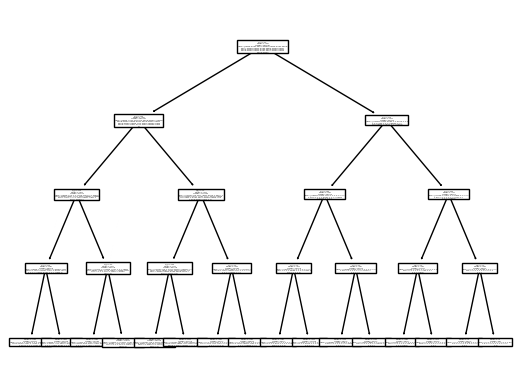

In [16]:
from sklearn import tree
from matplotlib import pyplot as plt

tree.plot_tree(model)
plt.show()